In [4]:
import sys
import os
from pathlib import Path
sys.path.append("..")
from .utils import build_features

import pandas as pd
import numpy as np
import seaborn as sns

sns.set_theme(style="darkgrid")

%load_ext autoreload
%autoreload 2

ImportError: attempted relative import with no known parent package

In [44]:
comp_prices_df = pd.read_csv("../data/comp_prices.csv")
sales_df = pd.read_csv("../data/sales.csv")

In [45]:
df = build_features(sales_df, comp_prices_df)

# Outliers
df = df[df.date != pd.to_datetime("2015-10-14")]

In [46]:
df

,prod_id,date,price,qty_order,min,max,mean,median,qty_day_shift,diff_min_pct,diff_mean_pct,qty_order_log
0,P1,2015-03-16,1402.312500,24.0,1362.50,1499.0,1446.137500,1461.525,48.0,0.029220,-0.030305,3.178054
1,P1,2015-03-17,1355.201071,28.0,1362.50,1499.0,1418.258333,1393.275,24.0,-0.005357,-0.044461,3.332205
2,P1,2015-03-18,1358.555075,67.0,1362.50,1499.0,1429.410000,1424.050,28.0,-0.002895,-0.049569,4.204693
3,P1,2015-03-19,1355.095217,46.0,1304.13,1499.0,1396.545000,1391.525,67.0,0.039080,-0.029680,3.828641
4,P1,2015-03-20,1384.065789,19.0,1304.13,1499.0,1440.454286,1499.000,46.0,0.061294,-0.039146,2.944439
...,...,...,...,...,...,...,...,...,...,...,...,...
1886,P9,2015-10-09,389.691600,175.0,395.85,569.0,433.183846,395.930,370.0,-0.015557,-0.100401,5.164786
1887,P9,2015-10-10,391.380233,129.0,395.82,569.0,433.146923,395.850,175.0,-0.011217,-0.096426,4.859812
1888,P9,2015-10-11,390.586437,87.0,395.78,569.0,444.330000,397.910,129.0,-0.013122,-0.120954,4.465908
1889,P9,2015-10-12,391.779727,110.0,395.76,569.0,439.895455,395.780,87.0,-0.010057,-0.109380,4.700480


In [47]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [67]:
prod_id = "P2"
sel_df = df[df.prod_id == prod_id]
X = sel_df[["diff_mean_pct", "qty_day_shift"]]
y = np.log(sel_df[["qty_order"]])
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
results.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              qty_order   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     153.8
Date:                Fri, 27 Aug 2021   Prob (F-statistic):           8.71e-46
Time:                        03:49:10   Log-Likelihood:                -334.04
No. Observations:                 283   AIC:                             674.1
Df Residuals:                     280   BIC:                             685.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.4835      0.055     81.950      0.000       4.376       4.591
diff_mean_pct   -10.0220      0.898    -11.162      0.000     -11.789      -8.255
qty_day_shift     0.0010      0.000      9.421      0.000       0.001       0.001
==============================================================================
Omnibus:                        3.353   Durbin-Watson:                   0.900
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                3.084
Skew:                          -0.194   Prob(JB):                        0.214
Kurtosis:                       3.334   Cond. No.                     9.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

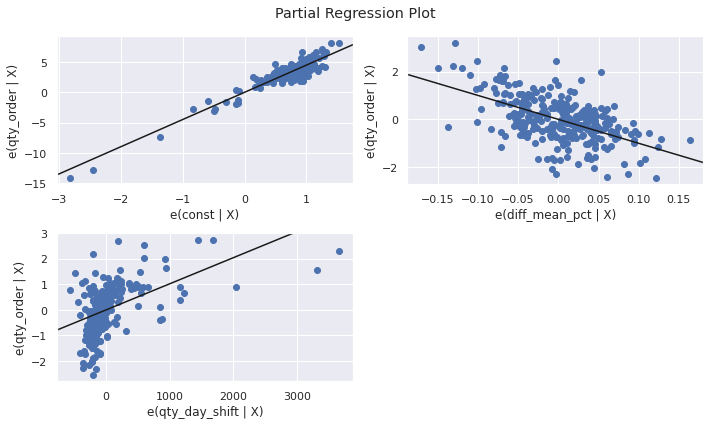

In [57]:

fig = sm.graphics.plot_partregress_grid(results)
fig.set_size_inches(10, 6)
fig.tight_layout(pad=1.0)


## Cross-validation score

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

for prod_id in df.prod_id.unique():
    sel_df = df[df.prod_id == prod_id]
    X = sel_df[["diff_mean_pct", "qty_day_shift"]]
    y = np.log(sel_df[["qty_order"]])
    reg = LinearRegression()
    mean_sqrt_error = np.exp(-cross_val_score(reg, X, y, cv=20, scoring="neg_root_mean_squared_error"))
    #plt.hist(mean_sqrt_error)
    #plt.show()
    print(f"Prod {prod_id}")
    print(f"Mean squared error: {np.mean(mean_sqrt_error)}")

Prod P1
Mean squared error: 1.8806480300176371
Prod P2
Mean squared error: 2.2511358373646257
Prod P3
Mean squared error: 1.9751947390946214
Prod P4
Mean squared error: 4.284373450877049
Prod P5
Mean squared error: 4.2128002199276136
Prod P6
Mean squared error: 2.123792041095981
Prod P7
Mean squared error: 2.1643794040100466
Prod P8
Mean squared error: 2.052740662336729
Prod P9
Mean squared error: 2.0120804432096735
